In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader

c:\Users\firda\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_excel(r"C:\Users\firda\OneDrive\Študijný materiál\VŠ\2024 LS 2.rocnik\NeuronoveSiete\Zadanie\moje data\vysledny_dataset.xlsx", sheet_name="Sheet1")

X = data.drop(columns=["Rozsev 0-5"])
y = data["Rozsev 0-5"]

#y_original = y.values.reshape(-1, 1)
scaler = StandardScaler()
#X = (X - X.mean()) / X.std()
X_scaled = scaler.fit_transform(X)

#scaler_y = MinMaxScaler()
#y_scaled = scaler_y.fit_transform(y_original)

# Splitting the dataset into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32) 
y_val = torch.tensor(y_val, dtype=torch.float32) 
y_test = torch.tensor(y_test, dtype=torch.float32)

train = TensorDataset(X_train, y_train)
test = TensorDataset(X_test, y_test)
val = TensorDataset(X_val, y_val)

# Vytvorenie dataloaders pre trénovaciu a testovaciu sadu
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
validation_loader = DataLoader(val, batch_size=64, shuffle=False)

In [10]:
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.3):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 1)  # Increase hidden units
        #self.fc2 = nn.Linear(256, 64)  # Additional fully connected layer
        #self.fc3 = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, _ = self.gru(x, h0)
        #out = F.relu(out)
        out = self.dropout(out)

        out = self.fc1(out[:, -1, :])
        #out = F.relu(out)
        #out = self.dropout(out)

        #out = self.fc2(out)
        #out = F.relu(out)
        #out = self.dropout(out)

        #out = self.fc3(out)

        return out

hidden_size = 32
num_layers = 2


In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, dropout = 0.4):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim 
        self.layer_dim = layer_dim 
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, 32)  
        self.fc1 = nn.Linear(32, 1)  
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

         # Forward propagation through LSTM layer
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out)
        # Index hidden state of last time step
        out = nn.functional.relu(self.fc(out[:, -1, :]))
        out = self.dropout(out)
        out = self.fc1(out)
        return out


In [328]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, dropout=0.4):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim  # Hidden dimensions
        self.layer_dim = layer_dim  # Number of hidden layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Fully connected layer

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation through LSTM layer
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out)
        # Reshape the output to fit into the fully connected layer
        out = self.fc(out[:, -1, :]) # Selecting the output from the last time step
        return out

In [4]:
num_epochs = 1000
input_dim = len(X.columns)  # Počet číselných atribútov vo vstupných dátach
hidden_dim = 100
layer_dim = 2

model = LSTMModel(input_dim, hidden_dim, layer_dim)
#model = RNN(input_dim, hidden_size, num_layers, dropout=0.2)

# Definícia straty a optimalizačného algoritmu
error = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [5]:
loss_list = []
iteration_list = []
validation_loss_list = [] 
iterations = 0
for epoch in range(num_epochs):
    model.train() 
    for i, (data, labels) in enumerate(train_loader):
       
        data = data.view(-1, 1, input_dim).requires_grad_()
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
        loss = error(outputs.squeeze(), labels)
        
        loss.backward()
        
        optimizer.step()
        iterations += 1

        
        if iterations % 100 == 0:
            loss_list.append(loss.item())
            iteration_list.append(iterations)

            # Výpis straty
            print('Iteration: {}. Loss: {}'.format(iterations, loss.item()))

            model.eval()  
            validation_loss = 0.0
            for data_val, labels_val in validation_loader:
                data_val = data_val.view(-1, 1, input_dim)
                outputs_val = model(data_val)
                loss_val = error(outputs_val.squeeze(), labels_val)
                validation_loss += loss_val.item() * data_val.size(0)  

            validation_loss /= len(validation_loader.dataset)  
            validation_loss_list.append(validation_loss)
            print('Validation Loss: {}'.format(validation_loss))

Iteration: 100. Loss: 11.953965187072754
Validation Loss: 12.803020992279052
Iteration: 200. Loss: 7.49177885055542
Validation Loss: 13.251914965311686
Iteration: 300. Loss: 5.322510719299316
Validation Loss: 14.869943408966064
Iteration: 400. Loss: 5.921044826507568
Validation Loss: 14.389600639343263
Iteration: 500. Loss: 3.9154231548309326
Validation Loss: 15.744767971038819
Iteration: 600. Loss: 4.386458873748779
Validation Loss: 13.761418972015381
Iteration: 700. Loss: 4.007136344909668
Validation Loss: 14.661168835957845
Iteration: 800. Loss: 2.171588897705078
Validation Loss: 17.005940481821696
Iteration: 900. Loss: 3.1076579093933105
Validation Loss: 15.462715371449788
Iteration: 1000. Loss: 2.4542200565338135
Validation Loss: 13.954077733357748
Iteration: 1100. Loss: 2.435932159423828
Validation Loss: 15.169693622589111
Iteration: 1200. Loss: 2.3740828037261963
Validation Loss: 15.372812232971192
Iteration: 1300. Loss: 2.9288573265075684
Validation Loss: 14.907797031402588
Ite

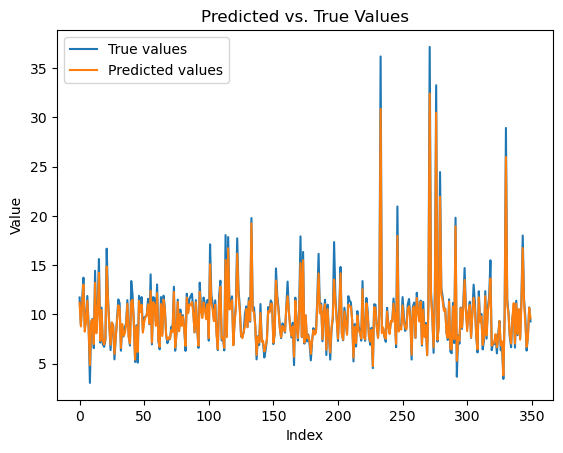

In [6]:
model.eval()

# Predikcia hodnôt pre testovaciu sadu
predicted_values = []
true_values = []

with torch.no_grad():
    for data, labels in train_loader:
        data = data.view(-1, 1, 25)
        outputs = model(data)
        predicted_values.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

# Vykreslenie grafu predikovaných a skutočných hodnôt
plt.plot(true_values, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values")
plt.legend()
plt.show()

In [7]:
model.eval()

# Predikcia na testovacej sade
with torch.no_grad():
    for data, labels in train_loader:
        # Predikcia
        outputs = model(data.view(-1, 1, input_dim))
        
        # Vypísanie predikovaných a skutočných hodnôt
        for i in range(len(outputs)):
            print("Predikovaná hodnota:", outputs[i].item(), "| Skutočná hodnota:", labels[i].item())

Predikovaná hodnota: 7.527428150177002 | Skutočná hodnota: 7.21999979019165
Predikovaná hodnota: 10.447525978088379 | Skutočná hodnota: 10.6899995803833
Predikovaná hodnota: 8.190865516662598 | Skutočná hodnota: 8.170000076293945
Predikovaná hodnota: 9.219486236572266 | Skutočná hodnota: 9.130000114440918
Predikovaná hodnota: 8.150869369506836 | Skutočná hodnota: 8.420000076293945
Predikovaná hodnota: 9.3109130859375 | Skutočná hodnota: 9.25
Predikovaná hodnota: 9.320289611816406 | Skutočná hodnota: 9.359999656677246
Predikovaná hodnota: 16.1627197265625 | Skutočná hodnota: 17.719999313354492
Predikovaná hodnota: 6.614522457122803 | Skutočná hodnota: 6.349999904632568
Predikovaná hodnota: 6.861814022064209 | Skutočná hodnota: 6.360000133514404
Predikovaná hodnota: 8.82887077331543 | Skutočná hodnota: 9.239999771118164
Predikovaná hodnota: 8.004704475402832 | Skutočná hodnota: 8.069999694824219
Predikovaná hodnota: 7.488345146179199 | Skutočná hodnota: 7.269999980926514
Predikovaná hodn

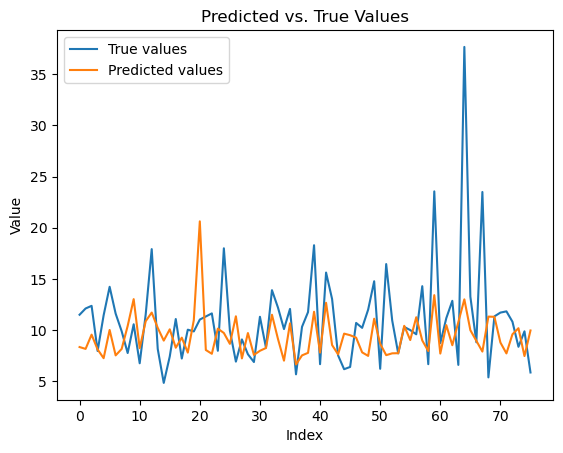

In [8]:
model.eval()

# Predikcia hodnôt pre testovaciu sadu
predicted_values = []
true_values = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.view(-1, 1, input_dim)
        outputs = model(data)
        predicted_values.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

# Vykreslenie grafu predikovaných a skutočných hodnôt
plt.plot(true_values, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values")
plt.legend()
plt.show()

In [9]:
model.eval()

# Predikcia na testovacej sade
with torch.no_grad():
    for data, labels in test_loader:
        # Predikcia
        outputs = model(data.view(-1, 1, input_dim))
        
        # Vypísanie predikovaných a skutočných hodnôt
        for i in range(len(outputs)):
            print("Predikovaná hodnota:", outputs[i].item(), "| Skutočná hodnota:", labels[i].item())

Predikovaná hodnota: 8.343992233276367 | Skutočná hodnota: 11.5
Predikovaná hodnota: 8.163468360900879 | Skutočná hodnota: 12.109999656677246
Predikovaná hodnota: 9.555610656738281 | Skutočná hodnota: 12.369999885559082
Predikovaná hodnota: 8.110943794250488 | Skutočná hodnota: 7.960000038146973
Predikovaná hodnota: 7.255680561065674 | Skutočná hodnota: 11.4399995803833
Predikovaná hodnota: 10.015119552612305 | Skutočná hodnota: 14.229999542236328
Predikovaná hodnota: 7.5301432609558105 | Skutočná hodnota: 11.609999656677246
Predikovaná hodnota: 8.159911155700684 | Skutočná hodnota: 9.890000343322754
Predikovaná hodnota: 10.406753540039062 | Skutočná hodnota: 7.760000228881836
Predikovaná hodnota: 13.025613784790039 | Skutočná hodnota: 10.569999694824219
Predikovaná hodnota: 8.235963821411133 | Skutočná hodnota: 6.760000228881836
Predikovaná hodnota: 10.871414184570312 | Skutočná hodnota: 11.539999961853027
Predikovaná hodnota: 11.712441444396973 | Skutočná hodnota: 17.90999984741211
P